In [2]:
import torch
from d2l import torch as d2l

In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()  # 设置matplotlib使用SVG格式来渲染图形
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本，长度为n_train，值介于0-5之间的数据，并排序

def f(x):  # 真实函数
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出，均值差，向量的形状
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [6]:
x_train

tensor([0.1471, 0.1516, 0.2988, 0.3132, 0.4155, 0.4477, 0.4601, 0.4789, 0.5981,
        0.7361, 0.7432, 1.0910, 1.1021, 1.1490, 1.2582, 1.2701, 1.4721, 1.6455,
        1.7998, 1.8603, 2.0819, 2.2787, 2.2798, 2.3418, 2.3668, 2.3848, 2.5454,
        2.6771, 2.7307, 2.7406, 2.9160, 2.9312, 3.0912, 3.2262, 3.6590, 3.6742,
        3.7752, 3.7753, 3.9810, 3.9901, 4.0290, 4.0735, 4.1393, 4.2632, 4.4367,
        4.4959, 4.5749, 4.7303, 4.8339, 4.9559])

In [7]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)  # 散点图，alpha透明度

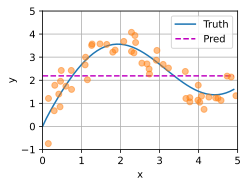

In [8]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

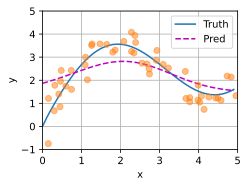

In [9]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

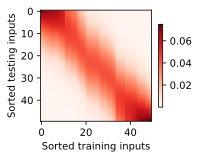

In [10]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [11]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape  # 对应batch做矩阵乘法

torch.Size([2, 1, 6])

In [12]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))  # unsqueeze(n)保持原数据不变的情况下，在第n维度上上添加一个维度

tensor([[[ 4.5000]],

        [[14.5000]]])

In [16]:
weights.shape,values.shape,weights.unsqueeze(1).shape,values.unsqueeze(-1).shape

(torch.Size([2, 10]),
 torch.Size([2, 10]),
 torch.Size([2, 1, 10]),
 torch.Size([2, 10, 1]))

In [ ]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)